In [1]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import time

Big parameters

In [3]:
pop_size = 100
half_pop_size = int(pop_size/2)
max_moves = 500

Initial population creation

In [4]:
population = np.random.choice([0,1], (pop_size, max_moves))

###GA functions

The fitness will be extracted directly from the environment as the number of moves performed before the end of the episode

In [32]:
def fitness_selection(fitnesses):
  half_pop_size = int(len(fitnesses)/2)
  pairs = np.random.choice(range(len(fitnesses)), size=(half_pop_size, 2), p=fitnesses/sum(fitnesses))
  return pairs

def rank_selection(fitnesses):
  half_pop_size = int(len(fitnesses)/2)
  pairs = np.random.choice(range(len(fitnesses)), size=(half_pop_size, 2), p=np.argsort(fitnesses)/sum(range(len(fitnesses))))
  return pairs

In [6]:
def crossover(pairs, population):
  pop_size = population.shape[0]

  new_gen = np.empty((pop_size, max_moves))
  for pair_nb in range(pairs.shape[0]):
    pair = pairs[pair_nb]
    dad = population[pair[0],:]
    mom = population[pair[1],:]

    for i in range(max_moves):
      if np.random.choice([True,False]):
        new_gen[2*pair_nb, i] = dad[i]
        new_gen[2*pair_nb+1, i] = mom[i]
      else:
        new_gen[2*pair_nb, i] = mom[i]
        new_gen[2*pair_nb+1, i] = dad[i]

  return new_gen

In [7]:
def mutation(population):
  pop_size = population.shape[0]

  for i in range(pop_size):
    for j in range(max_moves):

      if np.random.random() <= mutation_rate:
        population[i,j] = 1-population[i,j]
  return population

In [8]:
def pop_diversity(population):
  return np.std(population, 0).mean()

###Environment functions

In [9]:
def play_gen(population, env):
  pop_size = population.shape[0]
  fitnesses = np.empty(pop_size)

  for i in range(pop_size):
    env.reset()

    for t in range(max_moves):
      action = population[i,t]
      observation, reward, done, info, blc = env.step(action)

      if done : break

    fitnesses[i]=t

  return fitnesses

###Environment creation

In [10]:
env = gym.make("CartPole-v1")
population = np.random.choice([0,1], (pop_size, max_moves))

In [53]:
class GA_agent():

  def __init__(self, selection, nb_gen, pop_size, mutation_rate, elitism=0):
    if selection == "rank" : self.select = rank_selection
    elif selection=="fitness" : self.select = fitness_selection
    else : return "Unknown selection method"

    self.nb_gen = nb_gen
    self.pop_size = pop_size
    self.population = np.random.choice([0,1], (pop_size, max_moves))
    self.mutation_rate = mutation_rate
    self.elitism = elitism

    self.best_score = 0

    self.best_scores = np.empty(nb_gen)
    self.avg_scores = np.empty(nb_gen)
    self.diversity = np.empty(nb_gen)


  def evolve(self, timestep=0.5):
    self.best_per_second = []
    self.sample_times = []
    self.mean_score_timed = []
    self.max_score_timed = []

    last_time = time.time()
    start_time  = last_time

    for i in range(self.nb_gen):

      self.population = self.population.astype(int)

      self.diversity[i] = pop_diversity(self.population)

      fit = play_gen(self.population, env)

      if max(fit) > self.best_score: self.best_score = max(fit)

      now = time.time()
      if now - last_time >= timestep :
        self.best_per_second.append(self.best_score)
        last_time = now
        self.sample_times.append(now)
        self.mean_score_timed.append(np.mean(fit))
        self.max_score_timed.append(max(fit))


      elite = self.population[np.argmax(fit)].copy()

      self.best_scores[i] = max(fit)
      self.avg_scores[i] = np.mean(fit)

      # Selection
      pairs = self.select(fit)
      # Crossover
      self.population = crossover(pairs, self.population)
      # Mutation
      self.population = mutation(self.population)
      # Elitism
      self.population[np.random.choice(range(self.pop_size))] = elite 
    
    self.sample_times = np.array(self.sample_times)
    self.sample_times -= start_time


  def plot_evolution(self):
    plt.plot(self.best_scores, label="Best score")
    plt.plot(self.avg_scores, label="Average score")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over time")
    plt.show()

  def plot_evolution_per_second(self):
    plt.plot(self.sample_times, self.best_per_second, label="Best score")
    plt.plot(self.sample_times, self.mean_score_timed, label="Mean score")
    plt.plot(self.sample_times, self.max_score_timed, label="Max score")
    plt.legend()
    plt.xlabel("Seconds of training")
    plt.ylabel("Fitness")
    plt.title("Fitness over training time")
    plt.show()

  def plot_diversity(self):
    plt.plot(self.diversity, color="orange")
    plt.xlabel("Generation")
    plt.ylabel("Average gene STD")
    plt.title("Population diversity over time")
    plt.show()

In [54]:
agent = GA_agent("rank", 100, 20, mutation_rate)

In [55]:
agent.evolve()

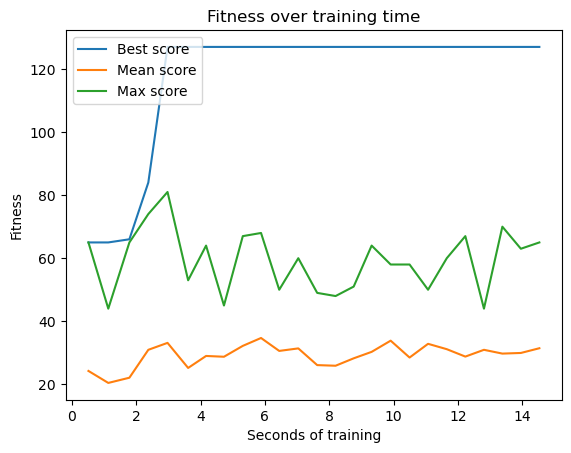

In [56]:
agent.plot_evolution_per_second()

In [ ]:
def evolve(selection, nb_gen, pop_size, mutation_rate, elitism=0):
  if selection == "rank" : select = rank_selection
  elif selection=="fitness" : select = fitness_selection
  else : return "Unknown selection method"

  population = np.random.choice([0,1], (pop_size, max_moves))

  best_scores = np.empty(nb_gen)
  avg_scores = np.empty(nb_gen)
  diversity = np.empty(nb_gen)

  for i in range(nb_gen):
    #print("Generation",i)

    population = population.astype(int)

    fit = play_gen(population, env)

    elite = population[np.argmax(fit)].copy()

    best_scores[i] = max(fit)
    avg_scores[i] = np.mean(fit)

    pairs = select(fit)

    population = crossover(pairs, population)

    population = mutation(population)

    population[np.random.choice(range(pop_size))] = elite

    diversity[i] = pop_diversity(population)

  plt.plot(best_scores, label="Best score")
  plt.plot(avg_scores, label="Average score")
  plt.legend()
  plt.xlabel("Generation")
  plt.ylabel("Fitness")
  plt.title("Fitness over time")
  plt.show()

  plt.plot(diversity, color="orange")
  plt.xlabel("Generation")
  plt.ylabel("Average gene STD")
  plt.title("Population diversity over time")
  plt.show()

  print("Final gen best score :", best_scores[nb_gen-1])
  print("Final gen average score :", avg_scores[nb_gen-1])

  return elite

In [13]:
nb_gen = 100
pop_size = 100
mutation_rate = 0.005

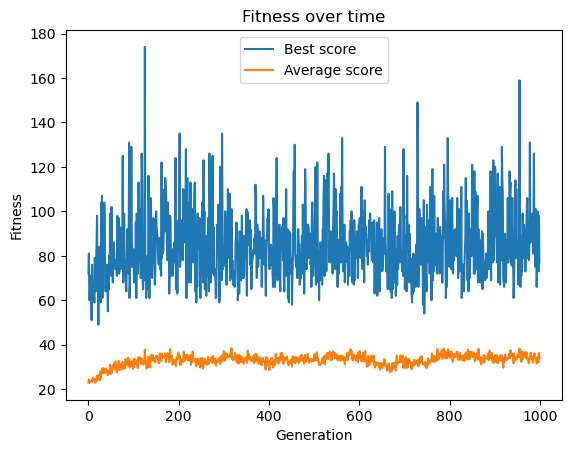

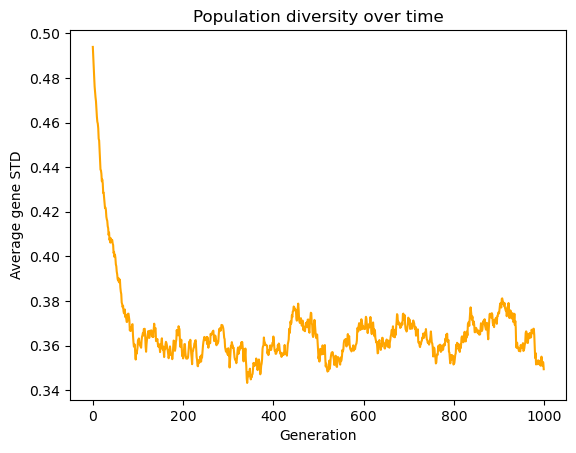

Final gen best score : 77.0
Final gen average score : 34.01


In [ ]:
best = evolve("fitness", nb_gen, pop_size, mutation_rate)

In [ ]:
play_gen(np.array([best]), env)

array([26.])